In [60]:
from skimage import io, color, morphology
from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk 
from skimage.util import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.filters import threshold_otsu
from skimage import segmentation
from skimage import measure
from skimage.color import label2rgb
import cv2 as cv2

In [61]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

**Exercise 1**

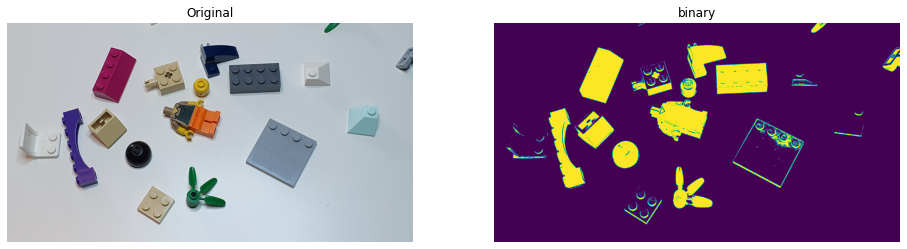

In [62]:
path = "data/"
img = io.imread(path + "lego_4_small.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thres = threshold_otsu(img_gray)
img_bin = img_gray < thres
show_comparison(img, img_bin, "binary")

**Exercise 2**

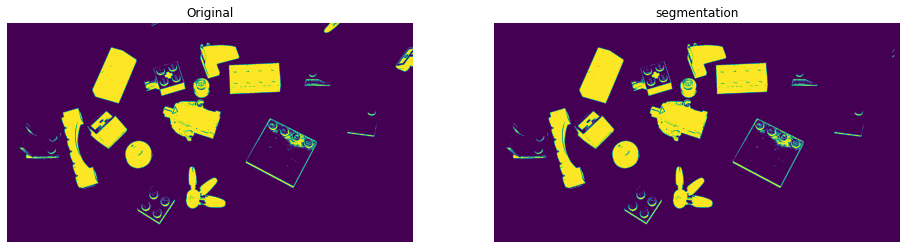

In [63]:
img_seg = segmentation.clear_border(img_bin)

show_comparison(img_bin, img_seg, "segmentation")

**Exercise 3**

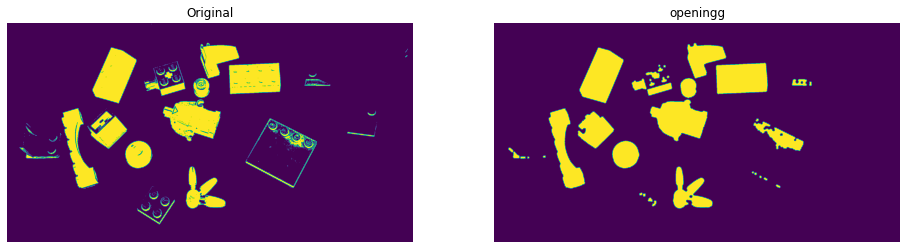

In [64]:
foot_c = disk(5)
img_close = closing(img_seg, foot_c)
foot_o = disk(5)
img_open = opening(img_close, foot_o)

show_comparison(img_seg, img_open, "openingg")


**Exercise 4**

In [65]:
label_img = measure.label(img_open)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

Number of labels: 37


**Exercise 5**

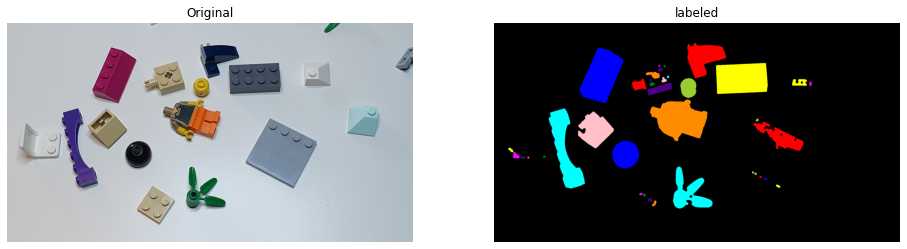

In [66]:
label = label2rgb(label_img)
show_comparison(img, label, "labeled")


**Exercise 6**

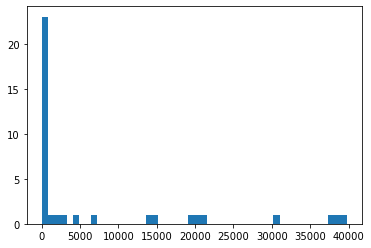

In [67]:
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=50)
plt.show()

**CELL COUNTING**

**Exercise 8: Threshold selection**

Select an appropriate threshold, that seperates nuclei from the background. You can set it manually or use Otsus method.

Show the binary image together with the original image and evaluate if you got the information you wanted in the binary image.

It can be seen that there is some noise (non-nuclei) present and that some nuclei are connected. Nuclei that are overlapping very much should be discarded in the analysis. However, if they are only touching each other a little we can try to separate them. More on this later.

To make the following analysis easier the objects that touches the border should be removed.

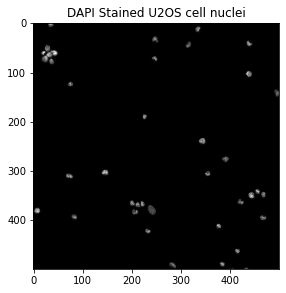

In [68]:
in_dir = "data/"
img_org = io.imread(in_dir + 'Sample E2 - U2OS DAPI channel.tiff')
# slice to extract smaller image
img_small = img_org[700:1200, 900:1400]
img_gray = img_as_ubyte(img_small) 
io.imshow(img_gray, vmin=0, vmax=150)
plt.title('DAPI Stained U2OS cell nuclei')
io.show()

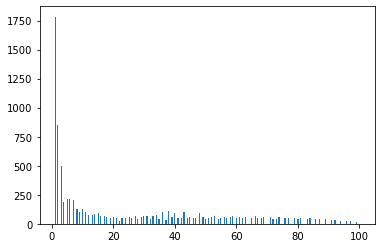

In [69]:
# avoid bin with value 0 due to the very large number of background pixels
plt.hist(img_gray.ravel(), bins=256, range=(1, 100))
io.show()

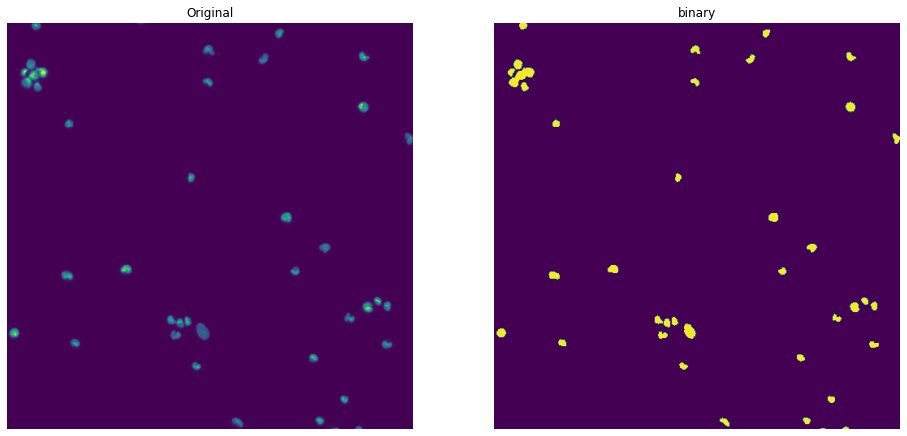

In [70]:
from skimage.filters import threshold_otsu

thres = threshold_otsu(img_gray)

img_bin = img_gray > thres

show_comparison(img_small, img_bin, "binary")

**Exercise 9: Remove border BLOBS**

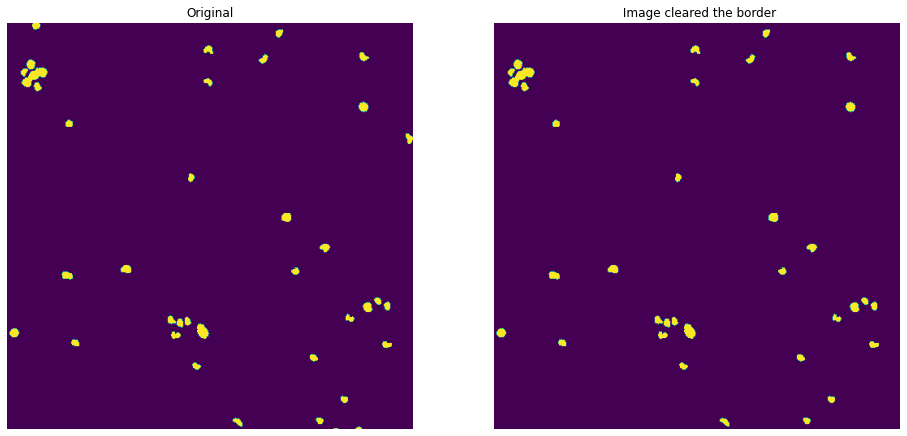

In [71]:
img_c_b = segmentation.clear_border(img_bin)
show_comparison(img_bin, img_c_b, " Image cleared the border")

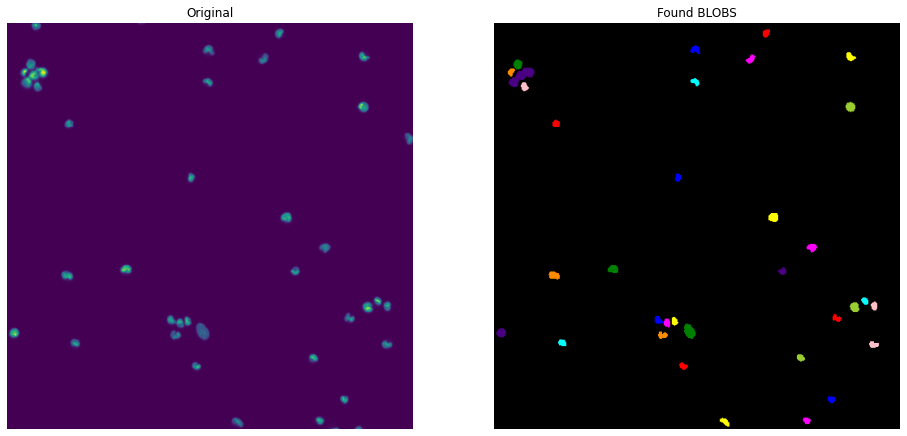

In [72]:

label_img = measure.label(img_c_b)
image_label_overlay = label2rgb(label_img)
show_comparison(img_gray, image_label_overlay, "Found BLOBS")

**Exercise 10: BLOB features**

In [73]:
region_props = measure.regionprops(label_img)

areas = np.array([prop.area for prop in region_props])


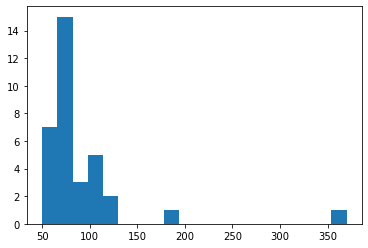

In [74]:
plt.hist(areas, bins=20, range=(50, 370))
io.show()

**Exercise 11: BLOB classification by area**


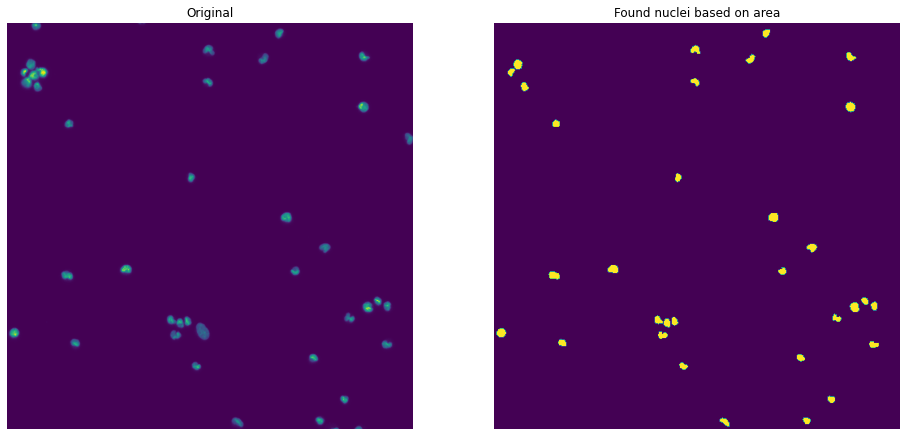

In [75]:
min_area = 50
max_area = 140

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, 'Found nuclei based on area')

**Exercise 12: Feature space**


In [76]:
print(len(region_props))

perimeters = np.array([prop.perimeter for prop in region_props])

print(len(perimeters))

34
34


Text(0, 0.5, 'perimeters')

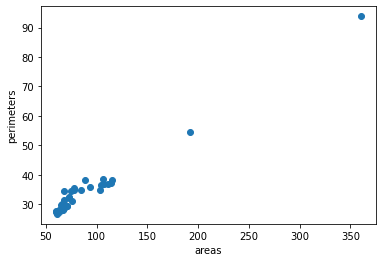

In [77]:
plt.scatter(areas, perimeters)
plt.xlabel("areas")
plt.ylabel("perimeters")

**Exercise 13: BLOB Circularity**


A circle has a circularity close to 1, and very-non-circular object have circularity close to 0.

In [81]:
def circularity(area, perimeter):
    '''
    You may get values larger than 1 because
    we are in a "discrete" (pixels) domain. Check:

    CIRCULARITY OF OBJECTS IN IMAGES, Botterma, M.J. (2000)
    https://core.ac.uk/download/pdf/14946814.pdf
    '''
    if (perimeter.any() == 0):
        f_circ = 0
    else:   
        f_circ = (4*np.pi*area)/(perimeter**2)
    return f_circ


In [79]:
circs = circularity(areas, perimeters)
print(circs)
plt.hist(circs, bins = 100)
plt.show

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# Lo que hice yo que no funciona
# values = circularity[circularity > 0.85 ]
# values = values[values < 1.15 ]

# # circularity_n = circularity[values]
# print(values)

Number of cells: 32


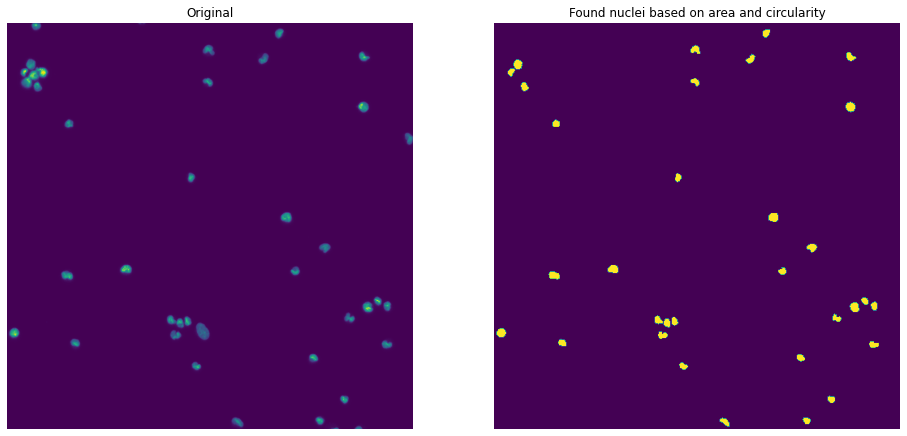

In [ ]:
min_circ = 0.7
min_area = 10 
max_area = 150

# Create a copy of the label_img
label_img_filter = label_img
cnt = 0
for region in region_props:
	circ = circularity(region.area, region.perimeter)
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area or circ < min_circ:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
	else:
    	 cnt +=1
# Create binary image from the filtered label image
i_area = label_img_filter > 0

print("Number of cells:", cnt)
show_comparison(img_small, i_area, 'Found nuclei based on area and circularity')

**Exercise 14: BLOB circularity and area**

Text(0, 0.5, 'circularity')

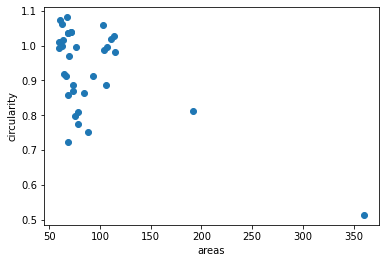

In [ ]:
plt.scatter(areas, circs)
plt.xlabel("areas")
plt.ylabel("circularity")

**Exercise 15: large scale testing**

Here we slide different parts of the data set to test the algorithm

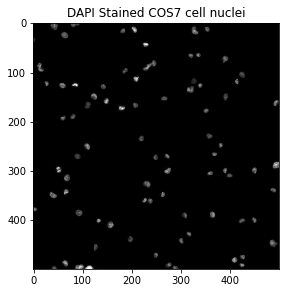

In [83]:

in_dir = "data/"
# img_org = io.imread(in_dir + 'Sample E2 - U2OS DAPI channel.tiff')
img_org = io.imread(in_dir + 'Sample G1 - COS7 cells DAPI channel.tiff')
# slice to extract smaller image
img_small = img_org[300:800, 300:800]
img_gray = img_as_ubyte(img_small) 
io.imshow(img_gray, vmin=0, vmax=150)
plt.title('DAPI Stained COS7 cell nuclei')
io.show()

74


C:\Users\joset\AppData\Local\Temp\ipykernel_3908\2299655384.py:12: RuntimeWarning: divide by zero encountered in true_divide
  f_circ = (4*np.pi*area)/(perimeter**2)


ValueError: supplied range of [0.4287697084780918, inf] is not finite

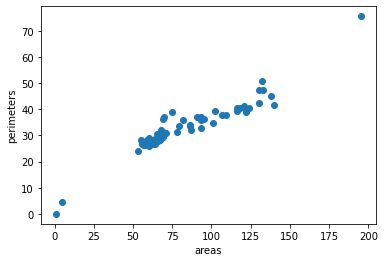

In [84]:
thres = threshold_otsu(img_gray)

img_bin = img_gray > thres
# show_comparison(img_small, img_bin, "binary")

img_c_b = segmentation.clear_border(img_bin)
# show_comparison(img_bin, img_c_b, "segmented")

label_img = measure.label(img_c_b)
image_label_overlay = label2rgb(label_img)
# show_comparison(img_gray, image_label_overlay, "Found BLOBS")

# to extract the areas
region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
# print(len(areas))

###############If you want to do classification by areas###############
# plt.hist(areas, bins=20, range=(50, 370))
# io.show()

# min_area = 50
# max_area = 70

# # Create a copy of the label_img
# label_img_filter = label_img
# for region in region_props:
# 	# Find the areas that do not fit our criteria
# 	if region.area > max_area or region.area < min_area:
# 		# set the pixels in the invalid areas to background
# 		for cords in region.coords:
# 			label_img_filter[cords[0], cords[1]] = 0
# # Create binary image from the filtered label image
# i_area = label_img_filter > 0
# show_comparison(img_small, i_area, 'Found nuclei based on area')

# Extract perimeters
perimeters = np.array([prop.perimeter for prop in region_props])
plt.scatter(areas, perimeters)
plt.xlabel("areas")
plt.ylabel("perimeters")

#Extract circularity
circs = circularity(areas, perimeters)
print(len(circs))
plt.hist(circs, bins = 100)
plt.show

min_circ = 0.9
min_area = 10 
max_area = 150

###############If you want to do classification with circularity###############
# Create a copy of the label_img
label_img_filter = label_img
cnt = 0
for region in region_props:
	circ = circularity(region.area, region.perimeter)
	# Find the areas that do not fit our criteria
	if region.area > max_area or region.area < min_area or circ < min_circ:
		# set the pixels in the invalid areas to background
		for cords in region.coords:
			label_img_filter[cords[0], cords[1]] = 0
	else:
    	 cnt +=1
# Create binary image from the filtered label image
i_area = label_img_filter > 0

print("Number of cells:", cnt)
show_comparison(img_small, i_area, 'Found nuclei based on area and circularity')